In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# we have a 6x9 grid of 54 squares
# we place a 1 layer thick wall around the outside
# each square has 4 values, up, down, left, right
# 0 = up, 1 = down, 2 = left, 3 = right

# Q values for each square, up, down, left, right for each square
maze_Q = np.zeros((6, 9, 4))

# going out of bounds is a -100 penalty
maze_Q[0, :, 0] = -10000
maze_Q[:, 0, 2] = -10000
maze_Q[5, :, 1] = -10000
maze_Q[:, 8, 3] = -10000

# reaching the goal is a 1 reward
maze_Q[0, 7, 3] = 8
maze_Q[1, 8, 0] = 8

maze_Q[0, 8, 1] = 8

initial_maze_Q = maze_Q.copy()

# set the maze whene the walls are represented by "W" and the goal by "G" and the current position by "*" and the empty squares by "0"
maze_1 = [["0", "0", "0", "0", "0", "0", "0", "0", "G"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["W", "W", "W", "W", "W", "W", "W", "W", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "*", "0", "0", "0", "0", "0"]]

maze_2 = [["0", "0", "0", "0", "0", "0", "0", "0", "G"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "W", "W", "W", "W", "W", "W", "W", "W"],
        ["0", "0", "0", "0", "0", "0", "0", "0", "0"],
        ["0", "0", "0", "*", "0", "0", "0", "0", "0"]]

# np.random.seed(29)

# going into the walls has -10000 penalty
maze_Q[4:8, 0, 0] = -10000
maze_Q[2:8, 0, 1] = -10000
maze_Q[3, 8, 2] = -10000

maze_action_count = np.zeros((6, 9, 4))

maze = maze_1.copy()


# np.random.seed(1)

In [3]:
def max_index(array):
    """ Returns the index of the maximum value of an array. If there are multiple maximum values, a random one is returned.

    Args:
        array (_type_): the array to find the maximum index of
    """
    max_value = np.max(array)
    max_index = np.where(array == max_value)[0]
    return np.random.choice(max_index)

In [4]:
# instead of giving the reward as the Q value, give the reward as it is only 1 when it is near the goal and 0 everywhere else

def move(x, y, a, maze):
    """make a move between squares in the maze. You can only move up, down, left, or right. Going out of bounds or into a wall
    will return the current position with a reward of -10000. Going into the goal will return the goal position with a reward of 1.

    Args:
        x (_type_): x coordinate of the current position
        y (_type_): y coordinate of the current position
        a (_type_): the action to take, 0 = up, 1 = down, 2 = left, 3 = right
        maze (_type_): the maze which we move in

    Raises:
        ValueError: ivalid action, you can only move up, down, left, or right

    Returns:
        _type_: the new x coordinate, the new y coordinate, and the reward
    """
    
    # if the action makes the agent go out of bounds, return the current position with a reward of -10000
    # if the action makes the agent go into a wall, return the current position with a reward of -10000
    
    if a == 0:
        if x == 0:
            return x, y, 0
        elif maze[x-1][y] == "W":
            return x, y, 0
        elif maze[x-1][y] == "G":
            return x-1, y, 1
        else:
            return x-1, y, 0
    elif a == 1:
        if x == 5:
            return x, y, 0
        elif maze[x+1][y] == "W":
            return x, y, 0
        elif maze[x+1][y] == "G":
            return x+1, y, 1
        else:
            return x+1, y, 0
    elif a == 2:
        if y == 0:
            return x, y, 0
        elif maze[x][y-1] == "W":
            return x, y, 0
        elif maze[x][y-1] == "G":
            return x, y-1, 1
        else:
            return x, y-1, 0
    elif a == 3:
        if y == 8:
            return x, y, 0
        elif maze[x][y+1] == "W":
            return x, y, 0
        elif maze[x][y+1] == "G":
            return x, y+1, 1
        else:
            return x, y+1, 0
    else:
        print("Invalid action, the action a must be 0(up), 1(down), 2(left), or 3(right)")
        raise ValueError("Invalid action")

In [5]:
def update_Q(x, y, a, maze_Q, learning_rate, discount_factor, discount, maze):
    """ Updates the Q value for the current position and action.

    Args:
        x (_type_): the x coordinate of the current position
        y (_type_): the y coordinate of the current position
        a (_type_): the action to take, 0 = up, 1 = down, 2 = left, 3 = right
        maze_Q (_type_): the Q values for each square
        learning_rate (_type_): the learning rate
        discount_factor (_type_): the discount factor
    """
    # get the next position
    x_next, y_next, reward = move(x, y, a, maze)

    # update the Q value
    if discount:
        Nxa = -0.005 * np.sqrt(maze_action_count[x, y, a])
    else:
        Nxa = 0
    maze_Q[x, y, a] = (1 - learning_rate) * maze_Q[x, y, a] + learning_rate * (reward + Nxa + discount_factor * np.max(maze_Q[x_next, y_next, :]))
    
    return x_next, y_next

In [6]:
# set the learning rate
learning_rate = 0.5

# set the discount factor
discount_factor = 0.9

time_steps_1 = 3000
time_steps_2 = 6000

repetition = 100 # we repeat the experiment 100 times and average the results to get a better estimate of the performance without noise

In [7]:
# Q- learning

total_cumulative_reward = np.zeros(time_steps_1 + time_steps_2)

for i in range(repetition):
    total_reward = 0

    cumulative_reward = []

    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()
    
    maze = maze_1.copy()
    
    for t in range(time_steps_1):
        
        a = max_index(maze_Q[x, y, :])
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)
            
    
    # switch to maze 2
    
    maze = maze_2.copy()
    
    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()

    for t in range(time_steps_2):
        
        a = max_index(maze_Q[x, y, :])
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)


    
    # add cumulative reward to total cumulative reward
    total_cumulative_reward += np.array(cumulative_reward)
    
# take the average cumulative reward
total_cumulative_reward /= repetition    

dyna_q_minus_average_cumulative_reward = total_cumulative_reward.copy()

In [8]:
maze_Q = initial_maze_Q.copy()

total_cumulative_reward = np.zeros(time_steps_1+time_steps_2)

for i in range(repetition):
    total_reward = 0

    cumulative_reward = []

    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()
    
    maze_action_count = np.zeros((6, 9, 4))
    maze = maze_1.copy()
    
    for t in range(time_steps_1):
        
        a = max_index(maze_Q[x, y, :])
        
        maze_action_count[x, y, a] += 1
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, True, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, True, maze)

            
    # switch to maze 2
    
    maze = maze_2.copy()
    
    x, y = [5, 3]
    
    maze_Q = initial_maze_Q.copy()
    
    maze_action_count = np.zeros((6, 9, 4))

    for t in range(time_steps_2):
        
        a = max_index(maze_Q[x, y, :])
        
        total_reward += maze_Q[x, y, a]
        
        cumulative_reward.append(total_reward)

        if x == 0 and y == 8:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)
            x, y = [5, 3]
        else:
            x, y = update_Q(x, y, a, maze_Q, learning_rate, discount_factor, False, maze)



    
    # add cumulative reward to total cumulative reward
    total_cumulative_reward += np.array(cumulative_reward)
    
# take the average cumulative reward
total_cumulative_reward /= repetition    

dyna_Q_plus_average_cumulative_reward = total_cumulative_reward.copy()



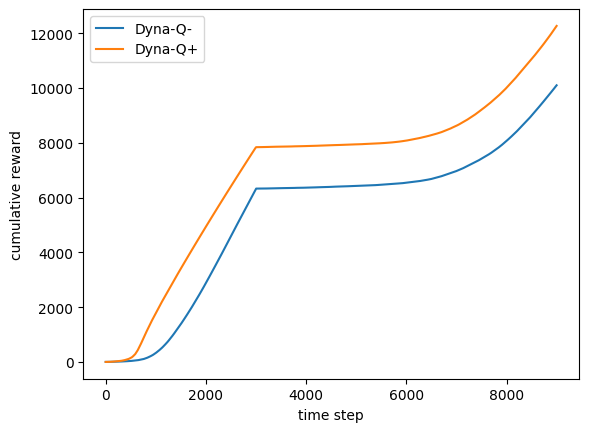

In [9]:
# plot the cumulative reward for both algorithms
plt.plot(dyna_q_minus_average_cumulative_reward, label="Dyna-Q-")
plt.plot(dyna_Q_plus_average_cumulative_reward, label="Dyna-Q+")
plt.legend()
plt.xlabel("time step")
plt.ylabel("cumulative reward")
plt.show()